In [1]:
import numpy as np
import sys,shutil,os
from scipy import linalg
import scipy.special as sysp
from scipy import stats 

sys.path.append('../code/')
from sbi import NeuralRatioEstimator

import copy,pickle
from time import time
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

import psutil

# cobaya imports
from cobaya.run import run
from cobaya.log import LoggedError
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12 # 14
mpl.rcParams['legend.labelspacing'] = 0.3
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of NeuralRatioEstimator
### simple NRE using Sequential NN tested on (non-)linear Gaussian problems

## Simulator setup

In [3]:
nparam = 2
ndata = 15

NReal = 10

File_Stem = 'poly' # 'poly','gaussmix'
if (File_Stem == 'poly') & (nparam > 2):
    File_Stem += '_deg{0:d}'.format(nparam-1)
if NReal != 10:
    File_Stem += '_avg{0:d}'.format(NReal)
Plots_Dir = File_Stem + '/plots/'
print('Using file stem:'+File_Stem)
print('Using plot dir :'+Plots_Dir)

class MyNRE(NeuralRatioEstimator):
    def __init__(self,params={}):
        NeuralRatioEstimator.__init__(self,params=params)

        if self.file_stem[:8] == 'gaussmix':
            if (self.nparam % 3) != 0:
                raise ValueError("param_dim must be multiple of 3")
            self.ncomp = self.nparam // 3
        
        # data variables and noise
        self.xvals = np.linspace(-1.5,3.5,self.ndata)
        # self.sigma = 8*np.linspace(0.05,0.2,self.ndata)
        self.sigma = np.linspace(0.1,0.5,ndata)
        self.cov_mat = np.diagflat(self.sigma**2)

        # prior mean,std
        self.prior_mean = np.zeros(self.nparam)
        self.prior_std = 6*np.ones(self.nparam)
        self.prior_cov = np.diagflat(self.prior_std**2)

        # # prior bounds
        # self.theta_min = -10*np.ones(self.nparam)
        # self.theta_max = 10*np.ones(self.nparam)
        # self.dtheta = self.theta_max - self.theta_min        
        
        return
    
    def simulator(self,theta):
        out = np.zeros((self.ndata,theta.shape[1]))
        if self.file_stem[:4] == 'poly':
            ####################
            # polynomial
            out += np.sum(np.array([np.outer(self.xvals**p,theta[p]) for p in range(self.nparam)]),axis=0)
            # for x in range(self.xvals.size):
            #     out[x] = np.sum([theta[p]*self.xvals[x]**p for p in range(self.nparam)])
            ####################
        else:
            for c in range(self.ncomp):
                amp = theta[c*3]
                mu = theta[c*3+1]
                mu = np.outer(np.ones(self.ndata),mu)
                lnsig2 = theta[c*3+2]
                # amp,mu,lnsig2 = theta[c*3:(c+1)*3,:]
                out += amp*np.exp(-0.5*(self.xvals-mu.T).T**2/np.exp(lnsig2))

        noise = self.rng.multivariate_normal(np.zeros(self.ndata),self.cov_mat,size=out.shape[1]) # shape (out.shape[1],out.shape[0])
        out += noise.T
        
        return out

    def prior(self,nsamp):
        theta = np.zeros((self.nparam,nsamp))
        
        for p in range(self.nparam):
            theta[p] = self.prior_mean[p] + self.rng.randn(nsamp)*self.prior_std[p]
            
        # for p in range(self.nparam):
        #     theta[p] = self.theta_min[p] + self.rng.rand(nsamp)*self.dtheta[p]
        
        return theta

Using file stem:poly
Using plot dir :poly/plots/


## Analytical ratio for linear Gaussian problem
#### with design matrix $\mathcal{M}$, data $y$, data covariance $C$, prior inverse covariance $F_{\rm (p)}$, prior mean $\theta_{\rm (p)}$, we have
#### $F = \mathcal{M}^{\rm T}C^{-1}\mathcal{M} + F_{\rm (p)}$
#### $\hat\theta = F^{-1}\left(\mathcal{M}^{\rm T}C^{-1}y + F_{\rm (p)}\theta_{\rm (p)}\right)$
#### $-2\ln p(\theta|x) = (\theta-\hat\theta)^{\rm T}\,F\,(\theta-\hat\theta) - \ln{\rm det}F + M\ln(2\pi)$
#### $-2\ln p(\theta) = (\theta-\theta_{\rm (p)})^{\rm T}\,F_{\rm (p)}\,(\theta-\theta_{\rm (p)}) - \ln{\rm det}F_{\rm (p)} + M\ln(2\pi)$
#### $2\ln r(y,\theta) = 2\ln\left[p(\theta|y)/p(\theta)\right] = (\mathcal{M}\theta)^{\rm T}C^{-1}(y-\mathcal{M}\theta) + \left(\mathcal{M}(\theta-\hat\theta)\right)^{\rm T}C^{-1}y - (\hat\theta-\theta_{\rm (p)})^{\rm T}F_{\rm (p)}\theta_{\rm (p)} + \ln\,{\rm det}(FF_{\rm (p)}^{-1})$

In [4]:
def analytical_nre(nre,X,theta):
    designM = np.ones((nre.ndata,nre.nparam))
    for p in range(nre.nparam):
        designM[:,p] = nre.xvals**p # monomial basis
    F_p = np.diagflat(1/nre.prior_std**2) # prior inv Cov
    theta_p = nre.cv(nre.prior_mean) # prior mean
    Cinv,detC = nre.svd_inv(nre.cov_mat) #np.diagflat(1/nre.sigma**2) # data inv Cov
    F = F_p + np.dot(designM.T,np.dot(Cinv,designM)) # posterior inv Cov
    theta_hat = np.dot(F_p,theta_p) # posterior mean
    theta_hat += np.dot(designM.T,np.dot(Cinv,X))
    theta_hat = np.dot(linalg.inv(F),theta_hat)

    Mtheta = np.dot(designM,theta)
    Mtheta_hat = np.dot(designM,theta_hat)

    lnr = np.dot(Mtheta.T,np.dot(Cinv,X-Mtheta))
    lnr += np.dot((Mtheta-Mtheta_hat).T,np.dot(Cinv,X))
    lnr -= np.dot((theta_hat-theta_p).T,np.dot(F_p,theta_p))
    lnr += np.log(linalg.det(F)) - np.log(linalg.det(F_p))
    lnr *= 0.5
    ratio = np.exp(lnr)    
    return ratio,F,theta_hat

## NRE setup and training

In [5]:
Train = True

ValFrac = 0.2

start_time = time()
if Train:
    Parallel = True
    
    L1 = 24 # 1 # number of layers with first activation
    AType1 = 'lrelu' # 'tanh'
    NNodes1 = 32 # 10,30,50,100,150,300,500
    L2 = 16 # 1 # number of layers with second activation
    AType2 = 'lrelu' # 'tanh'
    NNodes2 = 24 # 7,20,35,70,100,200,350
    L3 = 8 # 1 # number of layers with third activation
    AType3 = 'tanh' # 'tanh'
    NNodes3 = 16 # 20
        
    Share_Train_Data = True # True is more efficient (as expected) as well as higher quality (for some reason)
    
    Standardize = True
    Weight_Decay = 0.0 # 0.0
    LReLU_Slope = 1.5e-2 # 1e-2
    
    params = {'param_dim':nparam,'data_dim':ndata,'standardize':Standardize,'lrelu_slope':LReLU_Slope,
              'Lh':L1+L2+L3,'n_hidden_layer':[NNodes1]*L1+[NNodes2]*L2+[NNodes3]*L3,'hidden_atypes':[AType1]*L1+[AType2]*L2+[AType3]*L3,
              'wt_decay':Weight_Decay,'file_stem':File_Stem,'nreal':NReal,'parallel':Parallel,'share_train_data':Share_Train_Data}
    
    print('Setup...')
    nre_setup = MyNRE(params=params)
    NFree = nre_setup.net[1].calc_N_freeparams()

    Fac = 1.0 # 0.8,1,2,4 for shallow; 0.5 for deep
    NSamp = int(Fac*NFree/(1-ValFrac)) # 1*NFree 
    # NSamp = 50000 # 100k,50k    
    Complexity = NFree*NSamp
    # NSamp = 50000 # 640000 # ensure multiple of 100
    # Complexity = NFree*NSamp//100
    del nre_setup
    print('\nNFree = {0:d}; NSamp = {1:d}\n'.format(NFree,NSamp))
    
    if NReal > 1:
        for r in range(1,NReal+1):
            Path(File_Stem+'/r{0:d}'.format(r)).rmdir()

    File_Stem_This = File_Stem + '/C{0:d}'.format(Complexity)
    params['file_stem'] = File_Stem_This
    print('... setup complete with file stem:',params['file_stem'])
        
    nre = MyNRE(params=params)
    params_train = {'max_epoch':20000, # 16000
                    'lrate':3e-5 if L3 <= 4 else 1e-5, # 3e-5
                    'check_after':5000, # 1000
                    'mb_count':int(np.sqrt((1-ValFrac)*NSamp)),'val_frac':ValFrac}
    nre.train(NSamp,params=params_train)
    nre.save()
    nre.save_train(params_train)
else:
    #######################
    # NReal = 20 (multi KL)
    # progressive arch, proportional train size (train=0.8*free): 320445801,4329771601,34114459401
    #######################
    # NReal = 10 (multi KL)
    # progressive arch, proportional train size (train=4*free): 351125,6973805,37019205,399707405,1602229005,21648858005
    # progressive arch, proportional train size (train=2*free): 175430,3486312,18508242,199849232,801105552,10824396102
    # progressive arch, proportional train size (train=free): 87715,1743156,9254121,99924616,400552776,5412198051
    # progressive arch, proportional train size (train=0.8*free): 70225,194481,1394761,7403841,27050401,79941481,320445801,
    #                                                             4329771601,34114459401
    # (deep) progressive arch, proportional train size (train=0.5*free): 108420,1063575,3920325,15033825,211979670,854538470,
    #                                                                    3431432070 (try again w/ wt decay: 48,32,16,Fac=0.5)
    # (deep) progressive arch, proportional train size (train=free): 25277637,104353677,423977757,1709113917
    # fixed arch (50,35), progressive train size: 5442000,9251400,13605000,27210000
    # fixed arch (100,70), progressive train size: 17882000,44705000,100139200,178820000
    # fixed arch (500,350), progressive train size: 9235050000,18470100000
    #######################
    # NReal = 5
    # 483,723,2410,4410,27210,52010,81630,89410,156030,268230,272100,
    # 846100,894100,1200100,1790100,2682300,8941000
    #######################
    Complexity = 211979670
    File_Stem_This = File_Stem + '/C{0:d}'.format(Complexity)

# done like this to properly update saved loss histories in parallel calculation
with open(File_Stem_This + '/params.pkl', 'rb') as f:
    params = pickle.load(f)  
nre = MyNRE(params=params)
nre.load()
params_train = nre.load_train()
    
print('params_train:',params_train)
nre.time_this(start_time)

Setup...
... setting up 49 layer feed-forward neural network
... ... expecting data dim = 17, target dim = 1
... ... using hidden layers of sizes [32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,16,16,16,16,16,16,16,16]
... ... ... and activations [lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,lrelu,tanh,tanh,tanh,tanh,tanh,tanh,tanh,tanh]
... ... using last activation layer 'sigm'
... ... ... with threshold (None means default): None
... ... leaky ReLU will use slope = 1.50e-02
... ... using loss function 'nll'
... ... not using any regularization
... ... not using any weight decay
... setting up 49 layer feed-forward neural network
... ... expecting data dim = 17, target dim = 1
... ... using hidden layers of sizes [32,32,32,32,

min val loss...
... r1 = 7.334e-03
... r2 = 6.932e-01
... r3 = 6.931e-01
... r4 = 6.931e-01
... r5 = 5.230e-03
... r6 = 6.931e-01
... r7 = 6.931e-01
... r8 = 6.931e-01
... r9 = 6.902e-03
... r10 = 5.873e-03


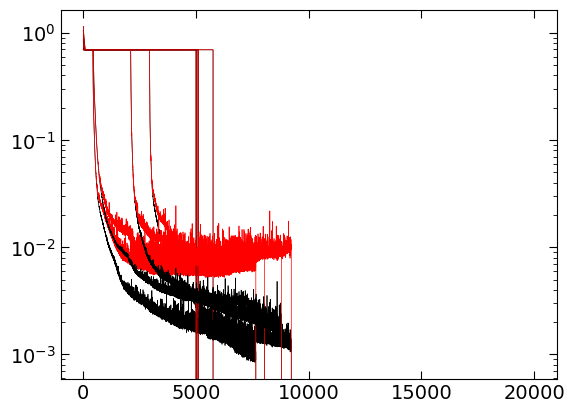

In [6]:
print('min val loss...')
plt.yscale('log')
for r in range(1,NReal+1):
    min_val_loss = nre.net[r].val_loss[nre.net[r].val_loss > 0.0].min()
    print('... r{0:d} = {1:.3e}'.format(r,min_val_loss))
    plt.plot(nre.net[r].epochs,nre.net[r].training_loss,'k-',lw=0.5)
    plt.plot(nre.net[r].epochs,nre.net[r].val_loss,'r-',lw=0.5)
plt.show()

## MCMC-based comparisons

In [7]:
N_repeat = 50
NProc = np.min([4,N_repeat]) 

print('Architecture:'+nre.file_stem+' ...')

Like_Dir = '../code/likes/'

Max_Samples = 1000000
Rminus1_Stop = 0.01 # 0.005
Rminus1_CL_Stop = 0.025 # 0.025
Rminus1_CL_Level = 0.95 # 95

Burn_In = 0
Burn_Frac = 0.3 # for later use

Latex_List = ['a_{{{0:d}}}'.format(p) for p in range(nre.nparam)]
Params_List = ['a{0:d}'.format(p) for p in range(nre.nparam)]

# Nd_ln_2pi = nre.ndata*np.log(2*np.pi)
# Cinv,detC = nre.svd_inv(nre.cov_mat)
# ln_det_Cd = np.log(detC)
# constant = -0.5*(Nd_ln_2pi + ln_det_Cd) 


info_nre = {}
info_nre['params'] = {}

info_nre['likelihood'] = {'likelihoods.NRELike':
                          {'python_path':Like_Dir}}

for p in range(len(Params_List)):
    ref = 0.0
    info_nre['params'][Params_List[p]] = {'ref':{'min':ref-0.001,'max':ref+0.001},
                                          'prior':{'dist':'norm','loc':nre.prior_mean[p],'scale':nre.prior_std[p]},
                                          'proposal':0.01,'latex':Latex_List[p]}

info_nre['sampler'] = {'mcmc':
                       {'learn_proposal': True,
                        'Rminus1_single_split': 4,
                        'measure_speeds': True,
                        'max_samples': Max_Samples,
                        'max_tries': 1000,
                        'Rminus1_stop': Rminus1_Stop,
                        'Rminus1_cl_stop': Rminus1_CL_Stop,
                        'Rminus1_cl_level': Rminus1_CL_Level,
                        'burn_in': Burn_In}}
info_output = File_Stem + '/stats/chains/'
chain_plot_path = info_output+'/for_plots'
Path(chain_plot_path).mkdir(parents=True, exist_ok=True)

info_nre["force"] = True    
info_nre["debug"] = 40 # 40 = only error output generated (https://docs.python.org/2/library/logging.html#logging-levels)

def run_chains(nre,info_nre,is_nre):
    updated_info_nre, sampler_nre = run(info_nre)
        
    # Load chains
    input_path = str(Path(info_nre["output"]).resolve()) # note info_nre
    gd_sample = loadMCSamples(input_path,settings={'ignore_rows':Burn_Frac})
    sample = gd_sample.samples.T
    
    # Subsample chains
    N_Boot = np.min([10000,int(0.2*sample[0].size)])
    Ind = gd_sample.random_single_samples_indices(random_state=42,max_samples=N_Boot)
    N_Boot = Ind.size
    
    # KL divergence D_{KL}(post_NRE || post_MCMC)
    data_this = (info_nre['theory']['likelihoods.NRETheory']['data'] 
                 if is_nre else 
                 info_nre['likelihood']['likelihoods.Chi2Like']['Y'].T)
    KL = 0.0
    for b in range(N_Boot):
        # lnPrior_b = -sample[-4,Ind[b]]
        theta_b = nre.cv(sample[:nre.nparam,Ind[b]])
        ratio,F,theta_hat = analytical_nre(nre,data_this,theta_b)
        ratio_NRE = nre.predict(data_this,theta_b)
        KL += np.log((ratio_NRE+1e-30)/(ratio+1e-30))
        # lnPostNRE_b = np.log(nre.predict(data_this,theta_b)) + lnPrior_b
        # # chi2_b = sample[-2,Ind[b]]
        # # lnPostMCMC_b = -0.5*chi2_b + lnPrior_b + constant
        # lnPostMCMC_b = np.log(ratio) + lnPrior_b
        # KL += lnPostMCMC_b - lnPostNRE_b
    KL /= (N_Boot*np.log(2))
    return KL

Tasks = []
print('... setting up tasks')
for r in range(N_repeat):
    theta_test_this = nre.prior(1)
    data_test_this = nre.simulator(theta_test_this)

    info_nre_r = copy.deepcopy(info_nre)
    nre_r = copy.deepcopy(nre)
    
    info_nre_r['output'] = info_output + 'nre_C{0:d}_r{1:d}'.format(Complexity,r+1)    
    info_nre_r['theory'] = {'likelihoods.NRETheory':
                            {'python_path':Like_Dir,'nre':nre_r,
                             'data':data_test_this,
                             'keys':Params_List}}
    
    if r == 0:
        Tasks.append((nre_r,info_nre_r,False,run_chains))
    Tasks.append((nre_r,info_nre_r,True,run_chains))

    del nre_r,info_nre_r
    gc.collect()
    
    nre.status_bar(r,N_repeat)

def queue_chains(r,nre,info_nre,is_nre,run_chains,mdict):
    # p = psutil.Process()
    # p.cpu_affinity([n])
    if not is_nre:
        info_this = copy.deepcopy(info_nre)
        data_this = info_this['theory']['likelihoods.NRETheory']['data'].copy()
        info_this['output'] = info_output + 'mcmc_C{0:d}_r{1:d}'.format(Complexity,r+1)
        info_this['likelihood'] = {'likelihoods.Chi2Like':
                                  {'python_path':Like_Dir,
                                   'X':nre.rv(nre.xvals),'Y':data_this.T,
                                   'cov_mat':nre.cov_mat}}
        if nre.file_stem[:8] == 'gaussmix':
            info_this['theory'] = {'examplelikes.GaussMixTheory':
                                  {'python_path':Like_Dir,
                                   'X':nre.rv(nre.xvals),'ncomp':nre.ncomp}}
        else:
            info_this['theory'] = {'examplelikes.PolyTheory':
                                  {'python_path':Like_Dir,
                                   'X':nre.rv(nre.xvals)}}
        del data_this
        gc.collect()
    else:
        info_this = info_nre
    KL = run_chains(nre,info_this,is_nre)
    mdict[r+1] = KL
    # mdict[r+1] = {'KL':KL,'data':info_nre['likelihoods.NRETheory']['data']}
    return

# from queuer import queue_chains

KLvals = np.zeros(N_repeat)
# Data = np.zeros((N_repeat,nre.ndata,1))
start_time = time()
KLDict = nre.run_processes(Tasks,queue_chains,NProc)
for r in range(N_repeat):
    KLvals[r] = KLDict[r+1]#['KL']
    # Data[r] = KLDict[r+1]['data']
    
print('... cleanup')

files = [f for f in Path().glob(info_output+'mcmc_C{0:d}_r1.*'.format(Complexity))]
for f in files:
    shutil.copy(f,chain_plot_path)

files = [f for f in Path().glob(info_output+'nre_C{0:d}_r1.*'.format(Complexity))]
for f in files:
    shutil.copy(f,chain_plot_path)

files = [f for f in Path().glob(info_output+'mcmc_C*.*')]
for f in files:
    Path.unlink(f)

files = [f for f in Path().glob(info_output+'nre_C*.*')]
for f in files:
    Path.unlink(f)

del Tasks
gc.collect()

nre.time_this(start_time)

Architecture:poly/C1709113917 ...
... setting up tasks
[....................] 100% done


[vivaldi-primo:1542159] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
[vivaldi-primo:1542161] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
[vivaldi-primo:1542164] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
[vivaldi-primo:1542157] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
[vivaldi-primo:1542212] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
[vivaldi-primo:1542386] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared

[mcmc] *ERROR* The chain has been stuck for 1000 attempts, stopping sampling. Make sure the reference point is sensible and initial covmat. For parameters not included in an initial covmat, the 'proposal' width set for each parameter should be of order of the expected conditional posterior width, which may be much smaller than the marginalized posterior width - choose a smaller rather than larger value if in doubt. You can also decrease the 'proposal_scale' option for mcmc, though small values will sample less efficiently once things converge. Or make your starting 'ref'tighter around an expected best-fit value
Alternatively (though not advisable) make 'max_tries: np.inf' (or 'max_tries: .inf' in yaml).
Current point: a0:-7.651833, a1:-0.08753044
Current result: LogPosterior(logpost=0.5815079277510362, logpriors=[-6.234704533127678], loglikes=array([6.81621246]), derived=[], finite=False)
Last proposal: [-1.97988753 -2.5246491 ]
With rejected result: LogPosterior(logpost=-9.88615772853

Process Process-19:
Traceback (most recent call last):
  File "/home/aseem/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/aseem/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_1485285/1916989724.py", line 133, in queue_chains
    KL = run_chains(nre,info_this,is_nre)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1485285/1916989724.py", line 55, in run_chains
    updated_info_nre, sampler_nre = run(info_nre)
                                    ^^^^^^^^^^^^^
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/run.py", line 143, in run
    sampler.run()
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/samplers/mcmc/mcmc.py", line 387, in run
    self.get_new_sample()
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/samplers/mcmc/mcmc.py", line 466, in get_new_sample_metropo

[mcmc] *ERROR* The chain has been stuck for 1000 attempts, stopping sampling. Make sure the reference point is sensible and initial covmat. For parameters not included in an initial covmat, the 'proposal' width set for each parameter should be of order of the expected conditional posterior width, which may be much smaller than the marginalized posterior width - choose a smaller rather than larger value if in doubt. You can also decrease the 'proposal_scale' option for mcmc, though small values will sample less efficiently once things converge. Or make your starting 'ref'tighter around an expected best-fit value
Alternatively (though not advisable) make 'max_tries: np.inf' (or 'max_tries: .inf' in yaml).
Current point: a0:-1.706699, a1:1.875935
Current result: LogPosterior(logpost=2.3373875476657497, logpriors=[-5.510728705076839], loglikes=array([7.84811625]), derived=[], finite=False)
Last proposal: [ -3.97866418 -14.85268461]
With rejected result: LogPosterior(logpost=-13.02696638353

Process Process-36:
Traceback (most recent call last):
  File "/home/aseem/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/aseem/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_1485285/1916989724.py", line 133, in queue_chains
    KL = run_chains(nre,info_this,is_nre)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1485285/1916989724.py", line 55, in run_chains
    updated_info_nre, sampler_nre = run(info_nre)
                                    ^^^^^^^^^^^^^
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/run.py", line 143, in run
    sampler.run()
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/samplers/mcmc/mcmc.py", line 387, in run
    self.get_new_sample()
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/samplers/mcmc/mcmc.py", line 466, in get_new_sample_metropo

[mcmc] *ERROR* The chain has been stuck for 1000 attempts, stopping sampling. Make sure the reference point is sensible and initial covmat. For parameters not included in an initial covmat, the 'proposal' width set for each parameter should be of order of the expected conditional posterior width, which may be much smaller than the marginalized posterior width - choose a smaller rather than larger value if in doubt. You can also decrease the 'proposal_scale' option for mcmc, though small values will sample less efficiently once things converge. Or make your starting 'ref'tighter around an expected best-fit value
Alternatively (though not advisable) make 'max_tries: np.inf' (or 'max_tries: .inf' in yaml).
Current point: a0:-4.372692, a1:0.01487525
Current result: LogPosterior(logpost=2.604046250959149, logpriors=[-5.686960633440158], loglikes=array([8.29100688]), derived=[], finite=False)
Last proposal: [-17.03912158  12.19108112]
With rejected result: LogPosterior(logpost=-15.8397734400

Process Process-46:
Traceback (most recent call last):
  File "/home/aseem/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/aseem/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_1485285/1916989724.py", line 133, in queue_chains
    KL = run_chains(nre,info_this,is_nre)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1485285/1916989724.py", line 55, in run_chains
    updated_info_nre, sampler_nre = run(info_nre)
                                    ^^^^^^^^^^^^^
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/run.py", line 143, in run
    sampler.run()
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/samplers/mcmc/mcmc.py", line 387, in run
    self.get_new_sample()
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/samplers/mcmc/mcmc.py", line 466, in get_new_sample_metropo

[mcmc] *ERROR* The chain has been stuck for 1000 attempts, stopping sampling. Make sure the reference point is sensible and initial covmat. For parameters not included in an initial covmat, the 'proposal' width set for each parameter should be of order of the expected conditional posterior width, which may be much smaller than the marginalized posterior width - choose a smaller rather than larger value if in doubt. You can also decrease the 'proposal_scale' option for mcmc, though small values will sample less efficiently once things converge. Or make your starting 'ref'tighter around an expected best-fit value
Alternatively (though not advisable) make 'max_tries: np.inf' (or 'max_tries: .inf' in yaml).
Current point: a0:-0.07548243, a1:-4.139855
Current result: LogPosterior(logpost=2.4108678445904745, logpriors=[-5.659508451673701], loglikes=array([8.0703763]), derived=[], finite=False)
Last proposal: [ 0.93599708 14.98396166]
With rejected result: LogPosterior(logpost=-12.87367738143

Process Process-48:
Traceback (most recent call last):
  File "/home/aseem/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/aseem/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_1485285/1916989724.py", line 133, in queue_chains
    KL = run_chains(nre,info_this,is_nre)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1485285/1916989724.py", line 55, in run_chains
    updated_info_nre, sampler_nre = run(info_nre)
                                    ^^^^^^^^^^^^^
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/run.py", line 143, in run
    sampler.run()
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/samplers/mcmc/mcmc.py", line 387, in run
    self.get_new_sample()
  File "/home/aseem/anaconda3/lib/python3.11/site-packages/cobaya/samplers/mcmc/mcmc.py", line 466, in get_new_sample_metropo

... cleanup
95 min 41.18 seconds



In [8]:
ind_finite = np.where(np.isfinite(KLvals))[0]
KL = np.median(KLvals[ind_finite])
KL84 = np.percentile(KLvals[ind_finite],84)
KL16 = np.percentile(KLvals[ind_finite],16)
KLstd = 0.5*(KL84 - KL16)
print('Used {0:d} of {1:d} measured values'.format(ind_finite.size,KLvals.size))
print('KL + lg(evidence) = {0:.4f} +- {1:.4f}\n'.format(KL,KLstd))

First_Arch = False

Arch_File = File_Stem + '/archs.pkl'
if First_Arch:
    archs = {Complexity:{'KL':KL,'KL84':KL84,'KL16':KL16,'KLstd':KLstd,'Nwts':nre.net[1].calc_N_freeparams()}}
else:
    print('Reading architecture data from:',Arch_File)
    with open(Arch_File, 'rb') as f:
        archs = pickle.load(f)  
    archs[Complexity] = {'KL':KL,'KL84':KL84,'KL16':KL16,'KLstd':KLstd,'Nwts':nre.net[1].calc_N_freeparams()}

print('Storing architecture data to:',Arch_File)
with open(Arch_File, 'wb') as f:
    pickle.dump(archs,f)  
archs

Used 46 of 50 measured values
KL + lg(evidence) = 46.7643 +- 37.6743

Reading architecture data from: poly/archs.pkl
Storing architecture data to: poly/archs.pkl


{175430: {'KL': 99.9858268397872,
  'KL84': 119.37251388415983,
  'KL16': 85.02370294553147,
  'KLstd': 17.17440546931418,
  'Nwts': 265},
 3486312: {'KL': 17.876512663142133,
  'KL84': 24.879980426600497,
  'KL16': 15.326942030015791,
  'KLstd': 4.776519198292353,
  'Nwts': 1181},
 18508242: {'KL': 13.284728018171716,
  'KL84': 34.152968409340794,
  'KL16': 6.5071770597989325,
  'KLstd': 13.82289567477093,
  'Nwts': 2721},
 199849232: {'KL': 8.662479783700553,
  'KL84': 16.794183091227126,
  'KL16': 5.43082557652466,
  'KLstd': 5.681678757351233,
  'Nwts': 8941},
 801105552: {'KL': 3.173799038580129,
  'KL84': 11.880892075655336,
  'KL16': 1.6695890223297105,
  'KLstd': 5.105651526662813,
  'Nwts': 17901},
 87715: {'KL': 84.06964327552453,
  'KL84': 109.4003258400122,
  'KL16': 69.43880893121624,
  'KLstd': 19.98075845439798,
  'Nwts': 265},
 1743156: {'KL': 26.249039990564015,
  'KL84': 95.53770034368836,
  'KL16': 17.0795162654736,
  'KLstd': 39.22909203910738,
  'Nwts': 1181},
 925

In [9]:
# Arch_File = File_Stem + '/archs.pkl'
# with open(Arch_File, 'rb') as f:
#     archs = pickle.load(f)  
# archs

In [10]:
Arch_File = File_Stem + '/archs.pkl'
with open(Arch_File, 'rb') as f:
    archs = pickle.load(f)  
Complexities = list(archs.keys())#[:-1] 
N_Archs = len(Complexities)
# storage for median,+error,-error,complexity,Nfree,Ntrain/Nfree
KLstats = np.zeros(N_Archs,dtype=[('KL',float),('KL+',float),('KL-',float),
                                  ('complexity',int),('Nwts',int),('freedom',float)]) 
for a in range(N_Archs):
    complexity = Complexities[a]
    KLstats['KL'][a] = archs[complexity]['KL']
    KLstats['KL+'][a] = archs[complexity]['KL84'] - archs[complexity]['KL']
    KLstats['KL-'][a] = archs[complexity]['KL'] - archs[complexity]['KL16']
    KLstats['complexity'][a] = complexity
    KLstats['Nwts'][a] = archs[complexity]['Nwts']
    KLstats['freedom'][a] = (1-ValFrac)*complexity/archs[complexity]['Nwts']**2

KLstats = np.sort(KLstats,order='complexity')

### Plot

In [11]:
Save_Fig = True

Show_MCMC = True
Show_NRE = True

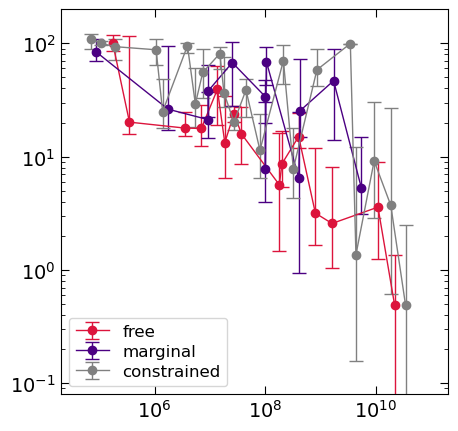

In [12]:
rng = np.random.RandomState(42)

plt.figure(figsize=(5,5))
plt.xlim(2e4,2e11)
plt.ylim(8e-2,2e2)
plt.xscale('log')
plt.yscale('log')
eps = 1e-1
# c8941 = (KLstats['Nwts'] == 8941)
cfree = (KLstats['freedom'] > 1+eps) #& ~c8941
plt.errorbar(KLstats['complexity'][cfree],
             KLstats['KL'][cfree],
             yerr=np.array([KLstats['KL-'][cfree],KLstats['KL+'][cfree]]),
             c='crimson',marker='o',capsize=5,label='free',lw=1)
cmarg = (np.fabs(KLstats['freedom'] - 1.0) <= eps) #& ~c8941
plt.errorbar(KLstats['complexity'][cmarg],
             KLstats['KL'][cmarg],
             yerr=np.array([KLstats['KL-'][cmarg],KLstats['KL+'][cmarg]]),
             c='indigo',marker='o',capsize=5,label='marginal',lw=1)
ccons = (KLstats['freedom'] < 1-eps) #& ~c8941
plt.errorbar(KLstats['complexity'][ccons],
             KLstats['KL'][ccons],
             yerr=np.array([KLstats['KL-'][ccons],KLstats['KL+'][ccons]]),
             c='gray',marker='o',capsize=5,label='constrained',lw=1)
# plt.errorbar(KLstats['complexity'][c8941],
#              KLstats['KL'][c8941],
#              yerr=np.array([KLstats['KL-'][c8941],KLstats['KL+'][c8941]]),
#              c='k',marker='o',capsize=5,label='Nwts = 8941',lw=1,alpha=0.1)
plt.legend(loc='lower left')
plt.show()

MCMC...
... best fit ( a0,...a1) = ( 2.4846e+00,-8.8620e-01 )
... std dev  ( a0,...a1) = ( 5.7574e-02,4.3946e-02 )
... chi2_best,dof,chi2_red,pval: 23.692,13,1.822,3.779e-02
NN...
... best fit ( a0,...a1) = ( 2.5108e+00,-9.5853e-01 )
... std dev  ( a0,...a1) = ( 2.8735e-01,1.2888e-01 )
... chi2_best,dof,chi2_red,pval: -16.112,13,-1.239,nan
Writing to file: poly/plots/contours_poly_C1709113917.png
0 min 0.41 seconds



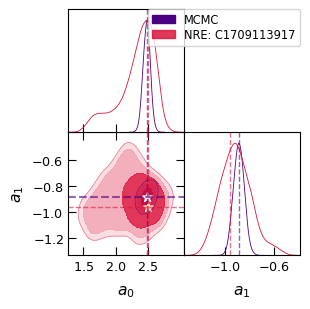

In [13]:
rng = np.random.RandomState(42)
n_params = len(nre.prior_mean)
dim = 1*n_params
dof = ndata - n_params

start_time = time()

# gd_sample = sampler.products(to_getdist=True)["sample"]

if Show_MCMC:
    gd_sample = loadMCSamples(str(Path(chain_plot_path+'/mcmc_C{0:d}_r1'.format(Complexity)).resolve()),
                                  settings={'ignore_rows':Burn_Frac})
    gd_sample.label = 'MCMC' 
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]
    sample = gd_sample.samples
    sample = sample.T
    ibest = sample[-2].argmin()
    mcmc_best = sample[:dim,ibest]
    mcmc_chi2 = sample[-2,ibest]
    pval = sysp.gammainc(mcmc_chi2/2,dof/2)
    mcmc_sig = np.sqrt(np.diag(mcmc_covmat))
    print('MCMC...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_best])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2,dof,mcmc_chi2/dof,pval))

if Show_NRE:
    gd_sample_nre = loadMCSamples(str(Path(chain_plot_path+'/nre_C{0:d}_r1'.format(Complexity)).resolve()),
                                  settings={'ignore_rows':Burn_Frac})
    gd_sample_nre.label = 'NRE: C{0:d}'.format(Complexity)
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat_nre = gd_sample_nre.getCovMat().matrix[:dim, :dim]
    sample_nre = gd_sample_nre.samples
    sample_nre = sample_nre.T
    iNRE_Id = sample_nre[-2].argmin()
    mcmc_NRE_Id = sample_nre[:dim,iNRE_Id]
    mcmc_chi2_nre = sample_nre[-2,iNRE_Id]
    pval_nre = sysp.gammainc(mcmc_chi2_nre/2,dof/2)
    mcmc_sig_nre = np.sqrt(np.diag(mcmc_covmat_nre))
    print('NN...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_NRE_Id])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig_nre])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2_nre,dof,mcmc_chi2_nre/dof,pval_nre))

plot_param_list = Params_List
Subplot_Size = 1.6

gdplot = gdplt.get_subplot_plotter(subplot_size=Subplot_Size)
gdplot.settings.num_plot_contours = 3
gdplot.settings.axes_fontsize = FS3
gdplot.settings.axes_labelsize = FS2
gdplot.settings.title_limit_fontsize = FS3

show_list = []
fill_list = []
col_list = []
if Show_MCMC:
    show_list.append(gd_sample)
    fill_list.append(True)
    col_list.append('indigo')
if Show_NRE:
    show_list.append(gd_sample_nre)
    fill_list.append(True)
    col_list.append('crimson')
gdplot.triangle_plot(show_list, plot_param_list,filled=fill_list,
                     contour_colors=col_list,legend_loc='upper right',
                     title_limit=0)
for par_y in range(dim):
    str_y = plot_param_list[par_y]
    ax = gdplot.subplots[par_y,par_y]
    if Show_MCMC:
        ax.axvline(mcmc_best[par_y],c='indigo',ls='--',lw=1,alpha=0.6)
    if Show_NRE:
        ax.axvline(mcmc_NRE_Id[par_y],c='crimson',ls='--',lw=1,alpha=0.6)
    for par_x in range(par_y):
        str_x = plot_param_list[par_x]
        ax = gdplot.subplots[par_y,par_x]
        if Show_MCMC:
            ax.scatter([mcmc_best[par_x]],[mcmc_best[par_y]],marker='*',s=50,c='aliceblue')
            ax.axvline(mcmc_best[par_x],c='indigo',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best[par_y],c='indigo',ls='--',lw=1.5,alpha=0.6)
        if Show_NRE:
            ax.scatter([mcmc_NRE_Id[par_x]],[mcmc_NRE_Id[par_y]],marker='*',s=50,c='peachpuff')
            ax.axvline(mcmc_NRE_Id[par_x],c='crimson',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_NRE_Id[par_y],c='crimson',ls='--',lw=1,alpha=0.6)

if Save_Fig:
    filename = 'contours_'+File_Stem+'_C{0:d}.png'.format(Complexity)
    print('Writing to file: '+Plots_Dir+filename)
    gdplot.export(fname=filename,adir=Plots_Dir)

nre.time_this(start_time)

In [14]:
# N_repeat = 50
# NProc = np.min([4,N_repeat]) 

# print('Architecture:'+nre.file_stem+' ...')

# Like_Dir = '../code/likes/'

# Run_MCMC = True
# Run_NRE = True

# Max_Samples = 1000000
# Rminus1_Stop = 0.01 # 0.005
# Rminus1_CL_Stop = 0.05 # 0.025
# Rminus1_CL_Level = 0.95 # 95

# Burn_In = 0
# Burn_Frac = 0.3 # for later use

# Latex_List = ['a_{{{0:d}}}'.format(p) for p in range(nre.nparam)]
# Params_List = ['a{0:d}'.format(p) for p in range(nre.nparam)]

# # Nd_ln_2pi = nre.ndata*np.log(2*np.pi)
# # Cinv,detC = nre.svd_inv(nre.cov_mat)
# # ln_det_Cd = np.log(detC)
# # constant = -0.5*(Nd_ln_2pi + ln_det_Cd) 


# info = {}
# info['params'] = {}

# if nre.file_stem[:8] == 'gaussmix':
#     info['theory'] = {'examplelikes.GaussMixTheory':
#                       {'python_path':Like_Dir,
#                        'X':nre.rv(nre.xvals),'ncomp':nre.ncomp}}
# else:
#     info['theory'] = {'examplelikes.PolyTheory':
#                       {'python_path':Like_Dir,
#                        'X':nre.rv(nre.xvals)}}
# for p in range(len(Params_List)):
#     ref = 0.0
#     info['params'][Params_List[p]] = {'ref':{'min':ref-0.001,'max':ref+0.001},
#                                       'prior':{'dist':'norm','loc':nre.prior_mean[p],'scale':nre.prior_std[p]},
#                                       'proposal':0.01,'latex':Latex_List[p]}

# info['sampler'] = {'mcmc':
#                    {'learn_proposal': True,
#                     'Rminus1_single_split': 4,
#                     'measure_speeds': True,
#                     'max_samples': Max_Samples,
#                     'max_tries': 1000,
#                     'Rminus1_stop': Rminus1_Stop,
#                     'Rminus1_cl_stop': Rminus1_CL_Stop,
#                     'Rminus1_cl_level': Rminus1_CL_Level,
#                     'burn_in': Burn_In}}
# info_output = File_Stem + '/stats/chains/'
# chain_plot_path = info_output+'/for_plots'
# Path(chain_plot_path).mkdir(parents=True, exist_ok=True)

# info["force"] = True    
# info["debug"] = 40 # 40 = only error output generated (https://docs.python.org/2/library/logging.html#logging-levels)

# info_nre = copy.deepcopy(info)
# info_nre['likelihood'] = {'likelihoods.NRELike':
#                          {'python_path':Like_Dir}}

# Tasks = []
# print('... setting up tasks')
# for r in range(N_repeat):
#     theta_test_this = nre.prior(1)
#     data_test_this = nre.simulator(theta_test_this)

#     info_r = copy.deepcopy(info)
#     info_nre_r = copy.deepcopy(info_nre)
#     nre_r = copy.deepcopy(nre)
    
#     info_r['output'] = info_output + 'mcmc_C{0:d}_r{1:d}'.format(Complexity,r+1)
#     info_nre_r['output'] = info_output + 'nre_C{0:d}_r{1:d}'.format(Complexity,r+1)    
#     info_r['likelihood'] = {'likelihoods.Chi2Like':
#                           {'python_path':Like_Dir,
#                            'X':nre.rv(nre.xvals),'Y':data_test_this.T,'cov_mat':nre.cov_mat}}
    
#     info_nre_r['theory'] = {'likelihoods.NRETheory':
#                              {'python_path':Like_Dir,
#                               'nre':nre_r,'data':data_test_this,'keys':Params_List}}
#     run_mcmc = Run_MCMC if r==0 else False
#     Tasks.append((nre_r,info_r,info_nre_r,run_mcmc,run_chains))

#     del nre_r,info_r,info_nre_r
#     gc.collect()
    
#     nre.status_bar(r,N_repeat)

# def queue_chains(r,nre,info,info_nre,run_mcmc,run_chains,mdict):
#     # p = psutil.Process()
#     # p.cpu_affinity([n])
#     KL = run_chains(nre,info,info_nre,run_mcmc)
#     mdict[r+1] = KL
#     # mdict[r+1] = {'KL':KL,'data':info_nre['likelihoods.NRETheory']['data']}
#     return


# def run_chains(nre,info,info_nre,run_mcmc):
#     # Run chains
#     if run_mcmc:
#     # if Run_MCMC:
#         updated_info, sampler = run(info)
#     # else:
#     #     print('Chains (hopefully) exist!')
    
#     if Run_NRE:
#         updated_info_nre, sampler_nre = run(info_nre)
#     # else:
#     #     print('Chains (hopefully) exist!')
#     # Load chains
#     # input_path = str(Path(info["output"]).resolve())
#     input_path = str(Path(info_nre["output"]).resolve()) # note info_nre
#     gd_sample = loadMCSamples(input_path,settings={'ignore_rows':Burn_Frac})
#     sample = gd_sample.samples.T
    
#     # Subsample chains
#     N_Boot = np.min([10000,int(0.2*sample[0].size)])
#     Ind = gd_sample.random_single_samples_indices(random_state=42,max_samples=N_Boot)
#     N_Boot = Ind.size
    
#     # KL divergence D_{KL}(post_NRE || post_MCMC)
#     data_this = info_nre['theory']['likelihoods.NRETheory']['data']
#     KL = 0.0
#     for b in range(N_Boot):
#         # lnPrior_b = -sample[-4,Ind[b]]
#         theta_b = nre.cv(sample[:nre.nparam,Ind[b]])
#         ratio,F,theta_hat = analytical_nre(nre,data_this,theta_b)
#         ratio_NRE = nre.predict(data_this,theta_b)
#         KL += np.log((ratio_NRE+1e-30)/(ratio+1e-30))
#         # lnPostNRE_b = np.log(nre.predict(data_this,theta_b)) + lnPrior_b
#         # # chi2_b = sample[-2,Ind[b]]
#         # # lnPostMCMC_b = -0.5*chi2_b + lnPrior_b + constant
#         # lnPostMCMC_b = np.log(ratio) + lnPrior_b
#         # KL += lnPostMCMC_b - lnPostNRE_b
#     KL /= (N_Boot*np.log(2))
#     return KL

# KLvals = np.zeros(N_repeat)
# # Data = np.zeros((N_repeat,nre.ndata,1))
# start_time = time()
# KLDict = nre.run_processes(Tasks,queue_chains,NProc)
# for r in range(N_repeat):
#     KLvals[r] = KLDict[r+1]#['KL']
#     # Data[r] = KLDict[r+1]['data']
    
# print('... cleanup')

# if Run_MCMC:
#     files = [f for f in Path().glob(info_output+'mcmc_C{0:d}_r1.*'.format(Complexity))]
#     for f in files:
#         shutil.copy(f,chain_plot_path)

# if Run_NRE:
#     files = [f for f in Path().glob(info_output+'nre_C{0:d}_r1.*'.format(Complexity))]
#     for f in files:
#         shutil.copy(f,chain_plot_path)

# files = [f for f in Path().glob(info_output+'mcmc*.*')]
# for f in files:
#     Path.unlink(f)

# files = [f for f in Path().glob(info_output+'nre_C*.*')]
# for f in files:
#     Path.unlink(f)

# del Tasks
# gc.collect()

# nre.time_this(start_time)